#### Amazon Movie Reviews Rating Prediction
###### This code trains a Random Forest Classifier to predict star ratings based on Amazon Movie Reviews.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

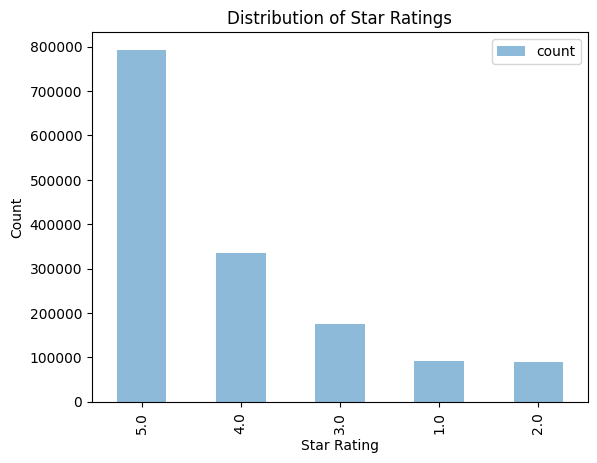


Vectorizing text data...
Applying Truncated SVD...
Combining features...
Splitting data into training and validation sets...
Training Random Forest Classifier...
Evaluating model...
Validation Accuracy: 0.5853378072688885


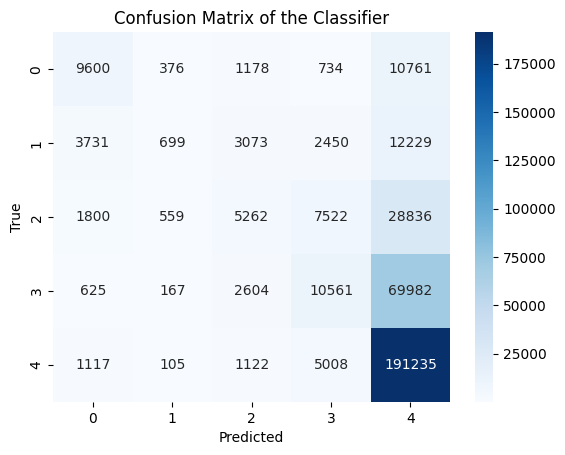

Predicting on test data...
Creating submission file...
Submission file created at './data/submission.csv'


In [2]:
# # # Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load the datasets
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

# Plot the distribution of scores
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()
print()

# Function to add features
def add_features_to(df):
    # Calculate helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Fill missing text and summary with empty strings
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')
    
    # Add text length features
    df['Text_length'] = df['Text'].apply(len)
    df['Summary_length'] = df['Summary'].apply(len)
    
    # Add word count features
    df['Text_word_count'] = df['Text'].apply(lambda x: len(x.split()))
    df['Summary_word_count'] = df['Summary'].apply(lambda x: len(x.split()))
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv') and exists('./data/X_submission.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # Merge on Id to include features in the submission set
    X_submission = pd.merge(train, testingSet, on='Id', how='right')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # Training set where the score is not null
    X_train = train[train['Score'].notnull()]
    
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Fill missing values in 'Text' and 'Summary' (if any)
X_train['Text'] = X_train['Text'].fillna('')
X_submission['Text'] = X_submission['Text'].fillna('')
X_train['Summary'] = X_train['Summary'].fillna('')
X_submission['Summary'] = X_submission['Summary'].fillna('')

# Feature Selection
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']

X_train_features = X_train[features]
X_submission_features = X_submission[features]

# Text Vectorization using TF-IDF
print("Vectorizing text data...")
text_vectorizer = TfidfVectorizer(max_features=10000)
text_vectorizer.fit(X_train['Text'])

X_train_text_tfidf = text_vectorizer.transform(X_train['Text'])
X_submission_text_tfidf = text_vectorizer.transform(X_submission['Text'])

# Dimensionality Reduction using Truncated SVD
print("Applying Truncated SVD...")
svd = TruncatedSVD(n_components=100, random_state=42)
svd.fit(X_train_text_tfidf)

X_train_text_svd = svd.transform(X_train_text_tfidf)
X_submission_text_svd = svd.transform(X_submission_text_tfidf)

# Combine numerical features and text features
print("Combining features...")
X_train_num = X_train_features.values
X_submission_num = X_submission_features.values

X_train_final = np.hstack((X_train_num, X_train_text_svd))
X_submission_final = np.hstack((X_submission_num, X_submission_text_svd))

# Target variable
Y_train = X_train['Score']

# Split into training and validation sets
print("Splitting data into training and validation sets...")
X_train_split, X_valid_split, Y_train_split, Y_valid_split = train_test_split(
    X_train_final, Y_train, test_size=0.25, random_state=42
)

# Model Creation
print("Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train_split, Y_train_split)

# Model Evaluation
print("Evaluating model...")
Y_valid_pred = model.predict(X_valid_split)
accuracy = accuracy_score(Y_valid_split, Y_valid_pred)
print("Validation Accuracy:", accuracy)

# Plot a confusion matrix
cm = confusion_matrix(Y_valid_split, Y_valid_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Predict on the test set
print("Predicting on test data...")
Y_submission_pred = model.predict(X_submission_final)

# Create submission file
print("Creating submission file...")
X_submission['Score'] = Y_submission_pred
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

print("Submission file created at './data/submission.csv'")